In [129]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [130]:
data_path = 'gene_expression_er.csv'
df_er = pd.read_csv(data_path)
df_er

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at,er
0,10.780787,8.674201,7.738589,9.285511,6.610484,8.505162,6.867181,7.168175,6.252700,5.262454,...,4.055948,4.659214,7.834107,8.957006,7.390298,8.603322,8.534263,8.404081,6.642913,0
1,11.335393,9.354759,7.763657,9.025809,4.809869,8.674612,5.097706,5.654260,9.892701,3.438981,...,4.721726,7.414131,7.492440,9.554207,7.221574,7.283642,8.195115,7.160975,7.526977,1
2,11.028074,9.053889,6.327600,9.234409,4.621973,8.406754,6.932156,6.263502,8.777121,4.738016,...,3.540740,7.450703,7.524904,8.971317,8.330001,8.351362,8.103304,7.279501,7.165591,0
3,11.847736,9.139895,7.032598,9.656416,5.589404,9.106449,7.751138,6.371654,11.993179,5.185123,...,2.910142,7.577435,7.405859,10.589735,8.189784,7.289380,8.506713,8.046931,6.439499,1
4,12.359239,9.196708,7.873428,9.174188,5.325173,10.030778,7.156790,4.057771,6.359531,6.061211,...,6.406668,8.519931,7.633125,9.052312,8.102586,9.102043,9.544095,7.166111,8.627155,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,10.785023,10.012078,6.855161,8.987488,5.833270,8.030344,5.473191,5.683147,10.456655,4.828817,...,2.118412,7.678996,8.450637,10.404560,7.430358,8.957046,6.040766,8.380360,6.680919,0
194,11.390198,9.830344,7.150656,8.766830,3.977743,8.014831,5.364158,6.170392,9.249901,5.571832,...,3.751159,7.351305,8.156723,10.123040,7.022056,9.623054,9.230266,7.466369,8.067021,0
195,10.735085,8.894038,7.262618,9.064142,3.781916,9.533836,7.063272,5.451382,8.613225,4.774023,...,3.067258,7.155768,5.589756,9.320891,7.252039,7.722694,8.463029,8.144946,6.995964,1
196,10.653104,8.854766,6.636791,9.283177,3.724769,9.722750,7.616948,4.402618,12.423745,5.884242,...,5.915134,8.147412,8.167496,10.205495,8.233159,7.431613,8.483289,8.829224,7.524969,1


There are 2216 genes and only 198 patients. We need to perform feature selection to train a machine learning model.
After research, several feature selection workflow have been used on transcriptomic data including : 


- Recursive feature elimination ([RFE](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-016-3317-7))

- Least absolute shrinkage and selection operator ([LASSO](https://www.nature.com/articles/s41598-021-92692-0))

- Differential gene expression (DGE) and F-score selection [Here (https://www.sciencedirect.com/science/article/pii/S2162253120300767)

We whose to used LASSO selection.


In [131]:
x = df_er.drop(columns=['er'])
y = df_er['er']

# standardize the data for dimensionality reduction 
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

x.head()

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
0,-0.800215,-0.156475,0.937822,0.051812,1.397760,-0.897219,0.241608,1.393678,-1.579403,-0.153397,...,-0.345504,-0.180527,-3.993632,0.661788,-0.155438,-0.201189,1.145302,0.274589,1.030150,-1.539724
1,0.129836,1.047900,0.970138,-0.705788,-0.110988,-0.600414,-2.673770,0.208818,0.465775,-2.066165,...,0.556082,0.353297,-0.071868,0.019822,0.772779,-0.430502,-0.926233,-0.039515,-0.892502,-0.063687
2,-0.385525,0.515454,-0.881125,-0.097262,-0.268428,-1.069589,0.348660,0.685639,-0.161027,-0.703517,...,0.317667,-0.593623,-0.019807,0.080819,-0.133195,1.075959,0.749794,-0.124546,-0.709184,-0.667059
3,0.989012,0.667657,0.027708,1.133812,0.542190,0.155986,1.698010,0.770284,1.645954,-0.234515,...,2.136304,-1.099240,0.160603,-0.142857,2.382282,0.885390,-0.917225,0.249073,0.477764,-1.879345
4,1.846782,0.768198,1.111647,-0.272938,0.320789,1.775029,0.718766,-1.040669,-1.519378,0.684474,...,0.142475,1.704292,1.502293,0.284159,-0.007306,0.766880,1.928156,1.209851,-0.884559,1.773178


In [132]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [133]:
pipeline = Pipeline([('model', Lasso())])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3)

In [134]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.103 total time=   1.1s
[CV 2/5] END .................model__alpha=0.1;, score=-0.116 total time=   0.7s
[CV 3/5] END .................model__alpha=0.1;, score=-0.104 total time=   0.6s
[CV 4/5] END .................model__alpha=0.1;, score=-0.154 total time=   0.5s
[CV 5/5] END .................model__alpha=0.1;, score=-0.174 total time=   0.6s
[CV 1/5] END .................model__alpha=0.2;, score=-0.131 total time=   0.4s
[CV 2/5] END .................model__alpha=0.2;, score=-0.158 total time=   0.5s
[CV 3/5] END .................model__alpha=0.2;, score=-0.123 total time=   0.5s
[CV 4/5] END .................model__alpha=0.2;, score=-0.180 total time=   0.5s
[CV 5/5] END .................model__alpha=0.2;, score=-0.174 total time=   0.5s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.187 total time=   0.4s
[CV 2/5] END .model__alpha=0.30000000000000004;

[CV 2/5] END .................model__alpha=2.1;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=2.1;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=2.1;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=2.1;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=2.2;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=2.2;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=2.2;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=2.2;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=2.2;, score=-0.241 total time=   0.4s
[CV 1/5] END ..model__alpha=2.3000000000000003;, score=-0.211 total time=   0.4s
[CV 2/5] END ..model__alpha=2.3000000000000003;, score=-0.235 total time=   0.4s
[CV 3/5] END ..model__alpha=2.3000000000000003;, score=-0.186 total time=   0.4s
[CV 4/5] END ..model__alpha=

[CV 4/5] END .................model__alpha=4.1;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=4.1;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=4.2;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=4.2;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=4.2;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=4.2;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=4.2;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=4.3;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=4.3;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=4.3;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=4.3;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=4.3;, score=-0.241 total time=   0.4s
[CV 1/5] END ..model__alpha=

[CV 1/5] END .................model__alpha=6.2;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=6.2;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=6.2;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=6.2;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=6.2;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=6.3;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=6.3;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=6.3;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=6.3;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=6.3;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=6.4;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=6.4;, score=-0.235 total time=   0.4s
[CV 3/5] END ...............

[CV 3/5] END .................model__alpha=8.2;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=8.2;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=8.2;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=8.3;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=8.3;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=8.3;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=8.3;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=8.3;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=8.4;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=8.4;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=8.4;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=8.4;, score=-0.257 total time=   0.4s
[CV 5/5] END ...............

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [135]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [136]:
importance = np.abs(coefficients)
probes_selected = np.array(x.columns)[importance > 0]
print(f"{len(probes_selected)} probes selected")
print(probes_selected)

28 probes selected
['201196_s_at' '201790_s_at' '201963_at' '202894_at' '203197_s_at'
 '203223_at' '203684_s_at' '203685_at' '203917_at' '203956_at' '204385_at'
 '204470_at' '205186_at' '205225_at' '205471_s_at' '205943_at'
 '207132_x_at' '208617_s_at' '208764_s_at' '209029_at' '209576_at'
 '209604_s_at' '210563_x_at' '211938_at' '214622_at' '217388_s_at'
 '217838_s_at' '221203_s_at']


In [137]:
df_er[probes_selected]

,201196_s_at,201790_s_at,201963_at,202894_at,203197_s_at,203223_at,203684_s_at,203685_at,203917_at,203956_at,...,208764_s_at,209029_at,209576_at,209604_s_at,210563_x_at,211938_at,214622_at,217388_s_at,217838_s_at,221203_s_at
0,9.848061,10.494364,12.677150,10.348075,9.961502,6.466060,3.066486,7.299545,10.820172,10.068476,...,12.579310,9.859017,8.485671,11.067215,10.627825,12.053945,5.583262,12.742921,8.891237,9.314181
1,10.001909,8.961490,8.871227,9.688557,9.702861,9.073238,5.834698,9.599270,5.772061,9.331605,...,12.592965,10.301422,5.685657,14.023003,10.467724,11.385603,3.328785,9.369179,9.855322,7.804451
2,10.538952,10.053360,9.548952,10.336838,9.648145,5.754082,3.013021,8.612907,13.069353,9.787590,...,11.949372,9.082100,7.190130,10.726372,10.603560,11.665887,4.092910,8.459995,9.678461,9.639825
3,8.627756,9.732431,9.125883,9.676061,9.585241,7.112622,3.854089,10.498765,7.884079,9.338613,...,12.991416,9.753622,6.424762,14.014380,10.725652,11.732913,4.520787,9.044168,9.294257,8.164054
4,7.765166,9.648644,10.382658,10.499267,9.858129,6.830208,7.786191,11.300058,9.670387,10.396689,...,13.271142,9.980930,6.775420,15.183723,9.516252,12.032796,6.770835,6.500645,12.079231,8.850277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,9.601304,9.489229,7.970101,9.988570,9.906498,5.102518,2.905019,9.019462,11.504894,9.236076,...,12.239465,10.587523,7.444037,10.090670,10.119872,11.488482,4.326447,7.581741,8.746099,8.960718
194,10.349537,8.677883,9.386835,9.162243,9.121194,6.758604,3.432785,6.632900,11.518119,9.291243,...,12.102846,9.732480,7.601218,9.857022,10.503905,11.596549,3.893544,7.987475,8.614434,9.130276
195,8.393997,8.129541,10.068518,9.042707,10.561966,7.061038,2.782885,10.043965,11.474425,9.135877,...,13.356923,9.774871,5.004223,14.576147,9.850507,12.308718,6.424055,7.945977,10.040405,8.581619
196,9.099542,8.233607,10.524078,9.322442,10.303320,6.946609,6.633564,10.462202,8.348854,9.757311,...,13.558436,9.703215,5.901967,14.005065,10.700209,12.522147,5.429858,8.305408,11.906226,8.671051


In [138]:
# replace probes name by gene name
annot = pd.read_csv('annot.csv')
gene_dico = dict(zip(annot['probe'], annot['HUGO.gene.symbol']))

gene_selected = [gene_dico[probe] for probe in probes_selected ]
print(gene_selected)


['AMD1', 'DHCR7', 'ACSL1', 'EPHB4', 'C1orf123', 'RABEP1', 'BCL2', 'BCL2', 'CXADR', 'MORC2', 'KYNU', 'CXCL1', 'DNALI1', 'ESR1', 'DACH1', 'TDO2', 'PFDN5', nan, 'ATP5G2', 'COPS7A', 'GNAI1', 'GATA3', 'CFLAR', 'EIF4B', 'CYP21A2', 'KYNU', 'EVL', 'YEATS2']


In [139]:
# lets try to now more about the functon of those genes
df_description = annot[annot['probe'].isin(probes_selected)][['probe','HUGO.gene.symbol','Description']]
df_description

,probe,HUGO.gene.symbol,Description
723,201196_s_at,AMD1,adenosylmethionine decarboxylase 1
1317,201790_s_at,DHCR7,7-dehydrocholesterol reductase
1490,201963_at,ACSL1,acyl-CoA synthetase long-chain family member 1
2421,202894_at,EPHB4,EPH receptor B4
2724,203197_s_at,C1orf123,chromosome 1 open reading frame 123
2750,203223_at,RABEP1,"rabaptin, RAB GTPase binding effector protein 1"
3210,203684_s_at,BCL2,B-cell CLL/lymphoma 2
3211,203685_at,BCL2,B-cell CLL/lymphoma 2
3443,203917_at,CXADR,coxsackie virus and adenovirus receptor
3482,203956_at,MORC2,MORC family CW-type zinc finger 2


Interestingly, ESR1, the estrogen receptor 1 has been selected.

In [141]:
def probe_to_gene(probe):
    'replace affymetric probe by gene name from annot file'
    if probe in gene_dico:
        return gene_dico[probe]
    else:
        return probe

gene_selected_er = np.append(probes_selected, 'er')
df_gene_selected_er = df_er[gene_selected_er]

df_gene_selected_er.columns = df_gene_selected_er.columns.to_series().apply(probe_to_gene)
# we remove Na gene
df_gene_selected_er = df_gene_selected_er.loc[:, df_gene_selected_er.columns.notnull()]

In [142]:
df_gene_selected_er.to_csv("df_gene_selected_lasso.csv", index=False)
df_gene_selected_er

,AMD1,DHCR7,ACSL1,EPHB4,C1orf123,RABEP1,BCL2,BCL2,CXADR,MORC2,...,COPS7A,GNAI1,GATA3,CFLAR,EIF4B,CYP21A2,KYNU,EVL,YEATS2,er
0,9.848061,10.494364,12.677150,10.348075,9.961502,6.466060,3.066486,7.299545,10.820172,10.068476,...,9.859017,8.485671,11.067215,10.627825,12.053945,5.583262,12.742921,8.891237,9.314181,0
1,10.001909,8.961490,8.871227,9.688557,9.702861,9.073238,5.834698,9.599270,5.772061,9.331605,...,10.301422,5.685657,14.023003,10.467724,11.385603,3.328785,9.369179,9.855322,7.804451,1
2,10.538952,10.053360,9.548952,10.336838,9.648145,5.754082,3.013021,8.612907,13.069353,9.787590,...,9.082100,7.190130,10.726372,10.603560,11.665887,4.092910,8.459995,9.678461,9.639825,0
3,8.627756,9.732431,9.125883,9.676061,9.585241,7.112622,3.854089,10.498765,7.884079,9.338613,...,9.753622,6.424762,14.014380,10.725652,11.732913,4.520787,9.044168,9.294257,8.164054,1
4,7.765166,9.648644,10.382658,10.499267,9.858129,6.830208,7.786191,11.300058,9.670387,10.396689,...,9.980930,6.775420,15.183723,9.516252,12.032796,6.770835,6.500645,12.079231,8.850277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,9.601304,9.489229,7.970101,9.988570,9.906498,5.102518,2.905019,9.019462,11.504894,9.236076,...,10.587523,7.444037,10.090670,10.119872,11.488482,4.326447,7.581741,8.746099,8.960718,0
194,10.349537,8.677883,9.386835,9.162243,9.121194,6.758604,3.432785,6.632900,11.518119,9.291243,...,9.732480,7.601218,9.857022,10.503905,11.596549,3.893544,7.987475,8.614434,9.130276,0
195,8.393997,8.129541,10.068518,9.042707,10.561966,7.061038,2.782885,10.043965,11.474425,9.135877,...,9.774871,5.004223,14.576147,9.850507,12.308718,6.424055,7.945977,10.040405,8.581619,1
196,9.099542,8.233607,10.524078,9.322442,10.303320,6.946609,6.633564,10.462202,8.348854,9.757311,...,9.703215,5.901967,14.005065,10.700209,12.522147,5.429858,8.305408,11.906226,8.671051,1


In [143]:
# EDA

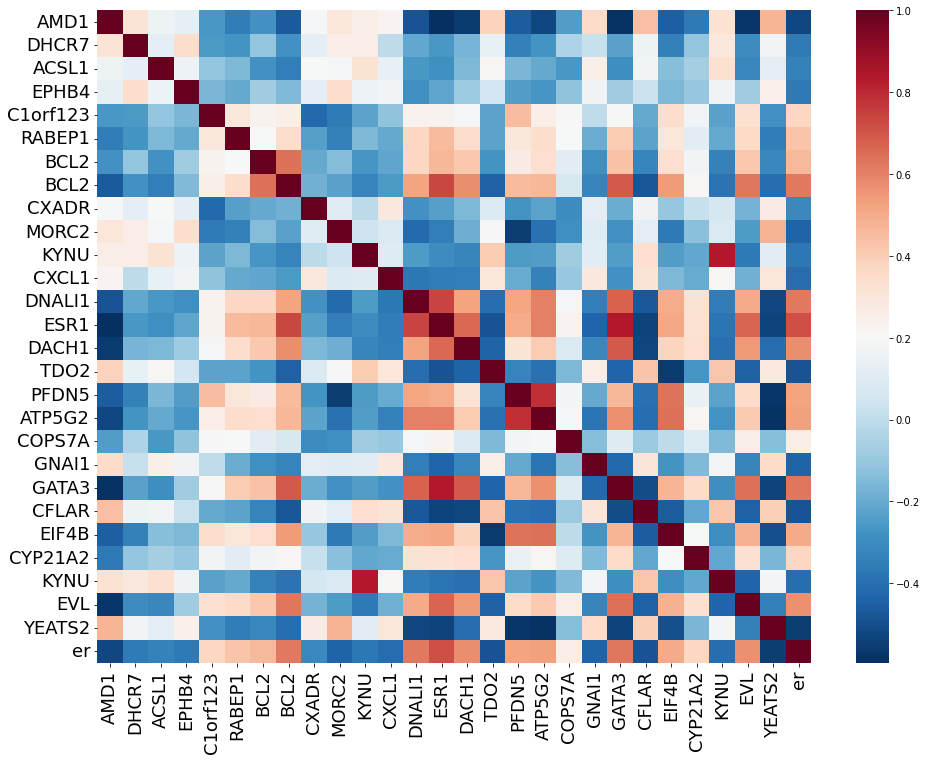

In [144]:
# Correlation heatmap

corr = df_gene_selected_er.corr()
plt.figure(figsize=(16, 12))

res = sns.heatmap(corr, 
            xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values, 
            annot_kws={"size": 80},
            cmap='RdBu_r')

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)

plt.show()

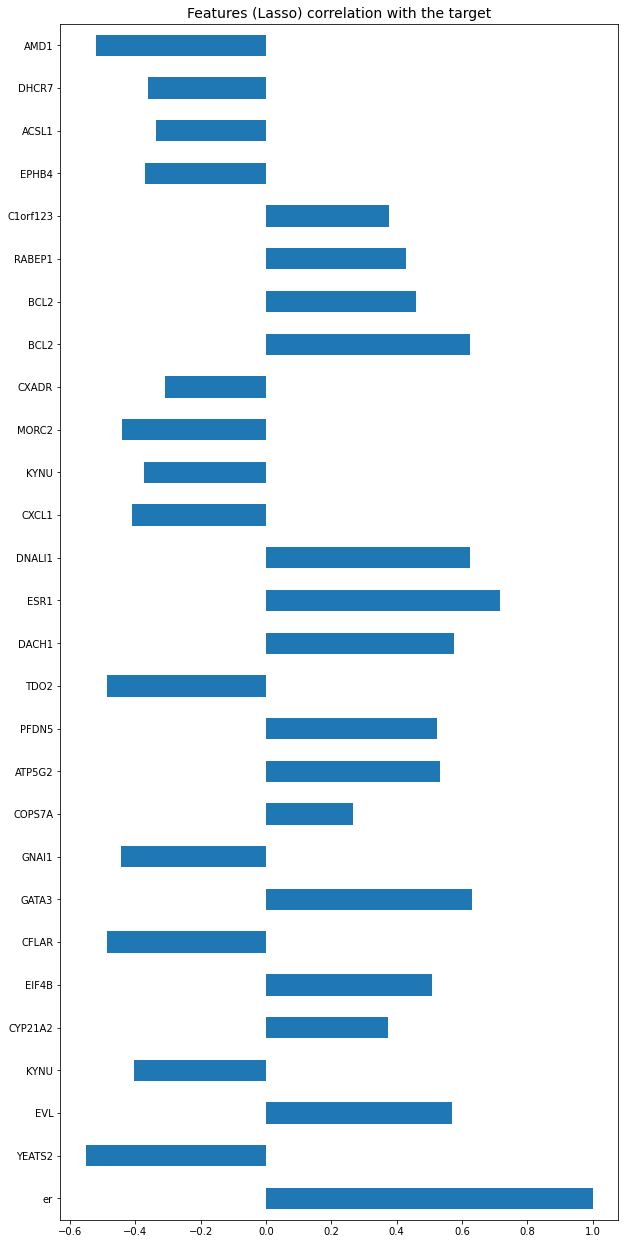

In [145]:
# Feature correlation with ER

plt.figure(figsize=(10, 22))
plt.title('Features (Lasso) correlation with the target', fontsize=14)
corr['er'].plot(kind='barh')
plt.gca().invert_yaxis()

We selected several gene using LASSO feature selection. Now, we are going to train classification model to predict ER positive and negative Breast cancer based on these selected gene.